In [ ]:
import os
import sys
sys.path.append('./Diffsound/')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import soundfile
import datetime
from pathlib import Path

from Diffsound.prompt2prompt import Controllers

from Diffsound.evaluation.generate_samples_batch import Diffsound
from Diffsound.sound_synthesis.utils.misc import seed_everything
import librosa
import librosa.display
import IPython.display

In [ ]:
class Diffsound_(Diffsound):
    def __init__(self, config, path, ckpt_vocoder, seed=0):
        super(Diffsound_, self).__init__(config, path, ckpt_vocoder)
        self.seed = seed

    def generate_sample(self, prompts, truncation_rate, save_root, content_token=None, controller=None, fast=False):
        batch_size = 8
        if fast != False:
            add_string = 'r,fast'+str(fast-1)
        else:
            add_string = 'r'

        generate_num = 0
        base_name_ = 'sample_'
        data_i = {}
        data_i['text'] = prompts
        data_i['image'] = None

        if controller is None:
            controller = Controllers.AttentionStore()

        with torch.no_grad():
            model_out = self.run_and_generate(
                data_i=data_i,
                filter_ratio=0,
                controller=controller,
                content_token=content_token,
                replicate=1,
                content_ratio=1,
                return_att_weight=False,
                sample_type="top"+str(truncation_rate)+add_string,
            )
            content = model_out['decode_content']
            content_token = model_out['content_token']
            # spec to sound
            os.makedirs(save_root, exist_ok=True)
            for b in range(content.shape[0]):
                print(f"text: {data_i['text'][generate_num]}")

                save_base_name = base_name_ + str(generate_num)
                spec = content[b]
                spec = spec.squeeze(0).cpu().numpy()
                spec = (spec + 1) / 2

                save_png_root = os.path.join(save_root, 'png')
                os.makedirs(save_png_root, exist_ok=True)
                save_png_name = os.path.join(save_png_root, save_base_name + '.png')
#                 print_spec(spec, save_png_name)

                # save spec
                save_spec_root = os.path.join(save_root, 'spec')
                os.makedirs(save_spec_root, exist_ok=True)
                save_spec_path = os.path.join(save_spec_root, save_base_name + '.npy')
                np.save(save_spec_path, spec)

                # save wav
                if self.vocoder is not None:
                    wave_from_vocoder = self.vocoder(torch.from_numpy(spec).unsqueeze(0).to(self.device)).cpu().squeeze().detach().numpy()
                    save_sound_root = os.path.join(save_root, 'sound')
                    os.makedirs(save_sound_root, exist_ok=True)
                    save_wav_path = os.path.join(save_sound_root, save_base_name + '.wav')
                    soundfile.write(save_wav_path, wave_from_vocoder, 22050, 'PCM_24')

                    wav_to_spectrogram(save_wav_path)

                    IPython.display.display(IPython.display.Audio(save_wav_path))

                generate_num += 1
        return content_token


def print_spec(spec, save_path):
    fig, ax = plt.subplots(figsize=(8, 3))
    img = librosa.display.specshow(
        spec[:, :512],
        sr=22050,
        x_axis='time',
        y_axis='linear',
        ax=ax,
        cmap=None)
    fig.colorbar(img, ax=ax, format="%+2.1f dB")
    plt.savefig(save_path)
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import librosa
import soundfile as sf

def wav_read(path):
    wave, fs = sf.read(path) #音データと周波数を読み込む
    return wave, fs

def wav_to_spectrogram(wav_file, n_mels=128, n_fft=2048, hop_length=512):
    plt.figure(figsize=(8,2))
    wave, fs = wav_read(wav_file)
    n_mels = 128
    fmax = 8000
    mel = librosa.feature.melspectrogram(y=wave, sr=fs, n_mels=n_mels, fmax=fmax)
    mel_dB = librosa.power_to_db(mel, ref=np.max) #dBに変換
    frq = librosa.mel_frequencies(n_mels=n_mels, fmax=fmax) #周波数軸
    t = librosa.frames_to_time(np.arange(mel_dB.shape[1]), sr=fs)  # 時間軸
    plt.pcolormesh(t, frq, mel_dB, cmap = 'jet')
    plt.show()
    plt.close()

In [ ]:
# Note that cap_text.yaml includes the config of vagan, we must choose the right path for it.
def run(
    Diffsound,
    prompts,
    save_root_ = './Diffsound/OUT',
    save_root = None,
    controller=Controllers.AttentionStore(),
    content_token = None):
    seed_everything(Diffsound.seed)
    if save_root is None:
        key_words = 'Real_vgg_pre_399'
        random_seconds_shift = datetime.timedelta(seconds=np.random.randint(60))
        now = (datetime.datetime.now() - random_seconds_shift).strftime('%Y-%m-%dT%H-%M-%S')
        save_root = os.path.join(save_root_, key_words + '_samples_'+now, 'caps_validation')
    content_token = Diffsound.generate_sample(prompts=prompts, content_token=content_token, truncation_rate=0.85, save_root=save_root, controller=controller, fast=False)
    return content_token

In [ ]:
config_path = './Diffsound/evaluation/caps_text.yaml'
pretrained_model_path = './Diffsound/pre_model/diffsound_audiocaps.pth'
ckpt_vocoder = './Diffsound/vocoder/logs/vggsound/'
diffsound = Diffsound_(config=config_path, path=pretrained_model_path, ckpt_vocoder=ckpt_vocoder, seed=0)

In [ ]:
prompts = [
    "Rain falls heavily on a metal roof and windows"
    ]
content_token = run(Diffsound=diffsound,prompts=prompts)

text: A piano music plays with whistling noise


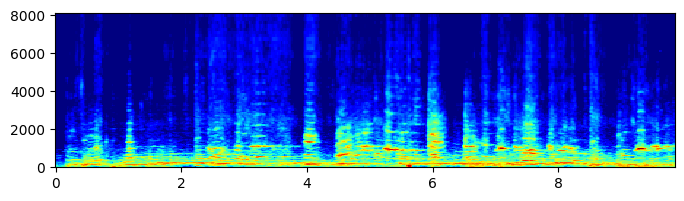

text: A jazz music plays with whistling noise


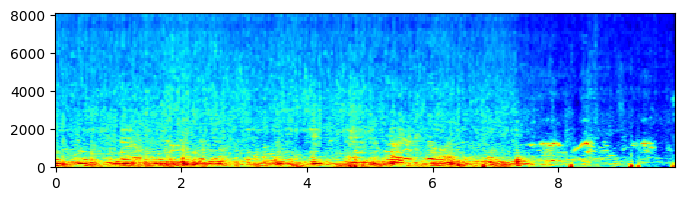

text: A sweet music plays with whistling noise


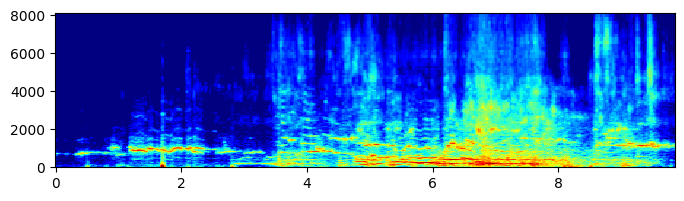

text: A soft music plays with whistling noise


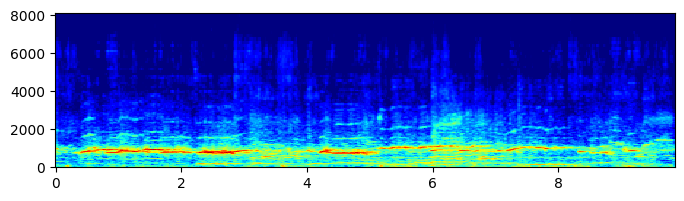

In [6]:
prompts = [
    "A piano music plays with whistling noise",
    "A jazz music plays with whistling noise",
    "A sweet music plays with whistling noise",
    "A soft music plays with whistling noise",
]
_ = run(diffsound, prompts, content_token=content_token)
controller = Controllers.AttentionReplace(prompts, 100, cross_replace_steps=.6, self_replace_steps=.4)
_ = run(diffsound, prompts, controller=controller, content_token=content_token)

In [ ]:
prompts = ["A man speaks before and after a gunshot"] * 4
equalizer = Controllers.get_equalizer(prompts[0], word_select=("gunshot",), values=(10, .0, -4))
controller = Controllers.AttentionReweight(prompts, 100, cross_replace_steps=1., self_replace_steps=.2, equalizer=equalizer)

_ = run(diffsound, prompts, content_token=content_token, controller=controller)

In [ ]:
prompts = [
    "A music plays with whistling noise",
    "A jazz music plays with whistling noise",
    "A sweet music plays with whistling noise",
    "A soft music plays with whistling noise",
]
_ = run(diffsound, prompts=prompts, content_token=content_token)

lb = Controllers.LocalBlend(prompts, ("music", ("jazz", "music"), ("sweet", "music"), ("soft", "music")))

controller =Controllers.AttentionRefine(prompts, 100, cross_replace_steps={"default_": 1., "music": .05},
                             self_replace_steps=.4, local_blend=lb)
_ = run(diffsound,prompts=prompts, content_token=content_token, controller=controller)